# Coche autónomo mediante Deep Learning

Autor: Andrés Martínez Martínez

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
model_output_dir = '/content/drive/My Drive/Colab Notebooks/Autonomous Car/model'

Mounted at /content/drive


##Imports

In [2]:
# imports

# common use
import os

# data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# machine learning
import tensorflow as tf
import keras
import cv2
from sklearn.model_selection import train_test_split

from imgaug import augmenters as iaa

print( f'tf.version: {tf.__version__}')
print( f'keras.version: {keras.__version__}')

tf.version: 2.8.2
keras.version: 2.8.0


##Load data

In [3]:
# import images
data_dir = '/content/drive/My Drive/Colab Notebooks/Autonomous Car/data'
image_list = os.listdir(data_dir)
image_paths = [data_dir + '/' + name for name in image_list]

# get list of angles from file names
steering_angles = [int(name[-7:-4]) for name in image_list]

##Prepare data

training examples: 1241
Validation examples: 311


Text(0.5, 1.0, 'Validation data')

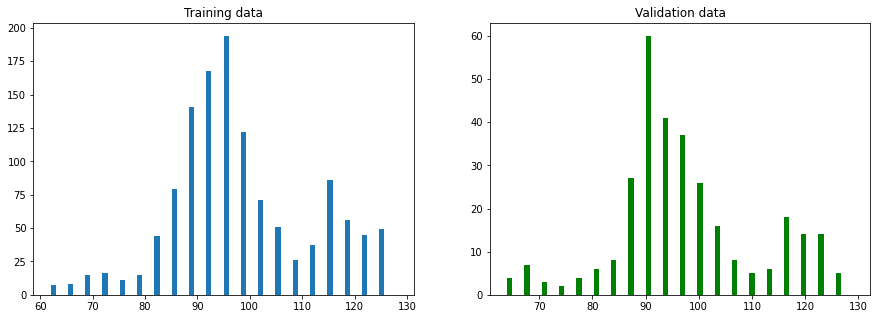

In [5]:
# split into test and training sets
X_train, X_val, y_train, y_val = train_test_split(image_paths, steering_angles, test_size=0.2)
print("training examples: %d\nValidation examples: %d" % (len(X_train), len(X_val)))

fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].hist(y_train, bins= 20, width=1)
axes[0].set_title('Training data')
axes[1].hist(y_val, bins= 20, width=1, color='green')
axes[1].set_title('Validation data')

##Image augmentation

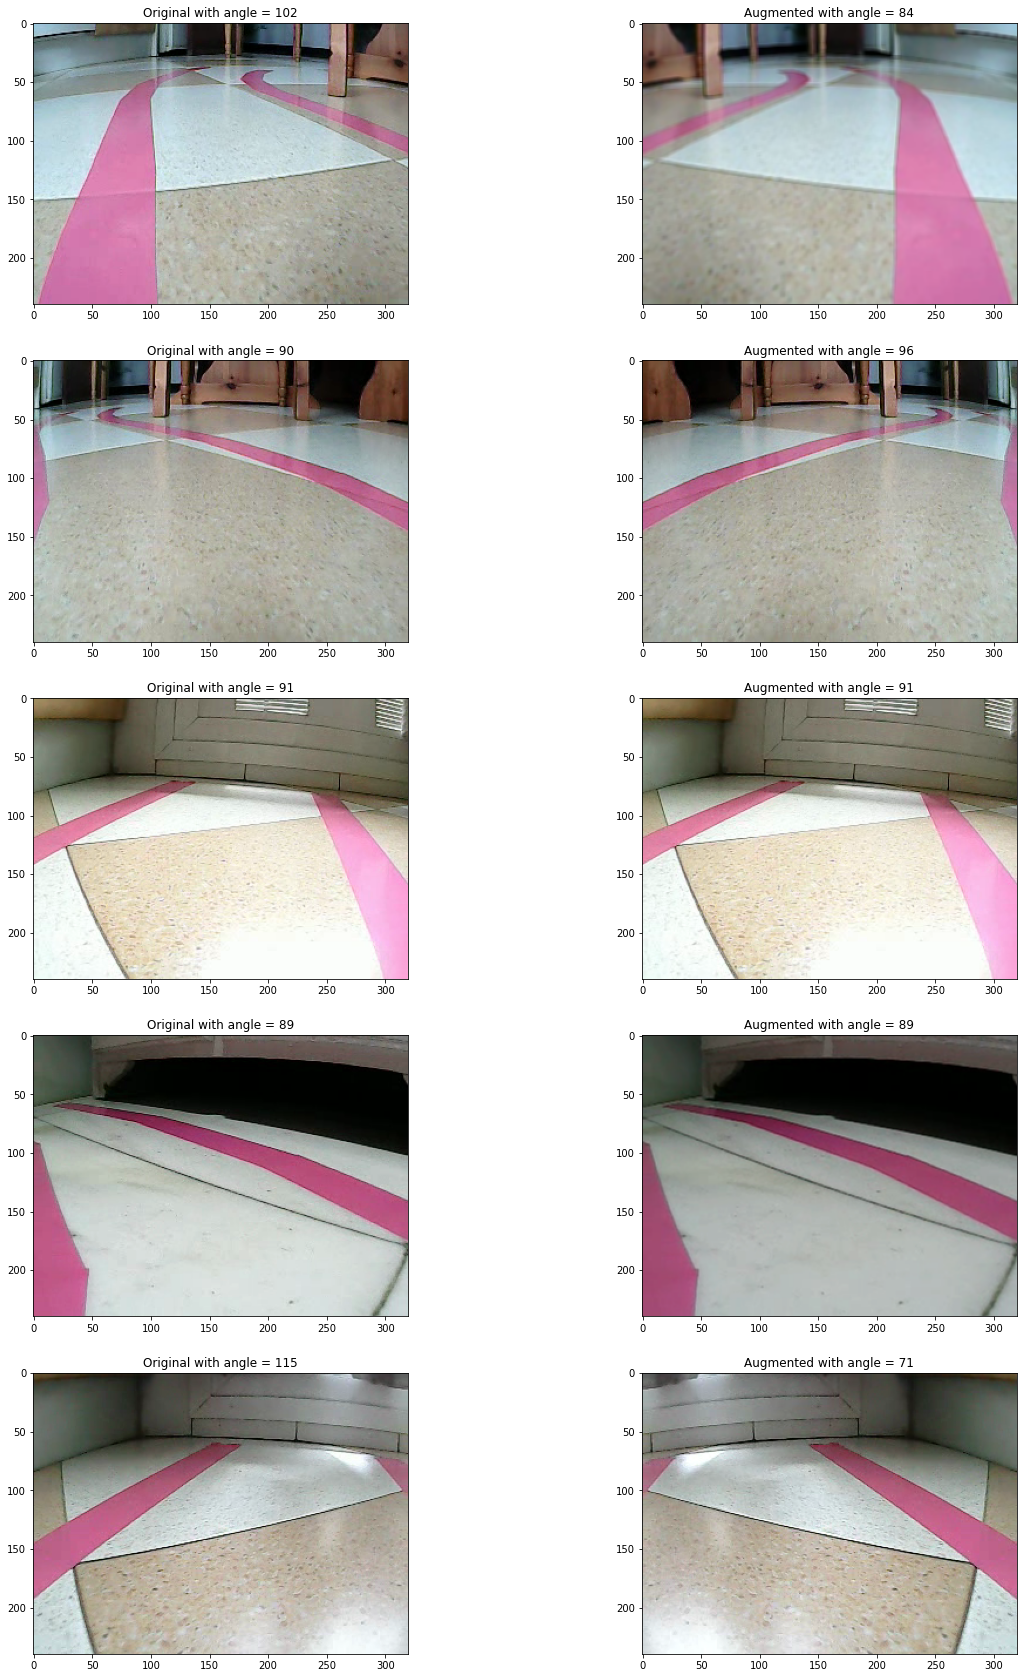

In [7]:
def flip(image, steering_angle):
  flipped_image = cv2.flip(image,1)
  steering_angle = 186 - steering_angle

  return flipped_image, steering_angle

def blur(image):
  ksize = np.random.randint(1,5)
  blurred_image = cv2.blur(image, (ksize,ksize))

  return blurred_image

'''def lower_brightnesss(image_path):
  image = Image.open(image_path)
  enhancer = ImageEnhance.Brigthness(image)

  factor = np.random.randint(5,10)/10
  darker_image = enhancer.enhance(factor)'''

'''def reduce_brightness(image):
  hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  hsv_array = np.array(hsv)

  bright_change = np.random.randint(5,10)/10
  hsv_array[:,2] *= bright_change
  hsv = hsv_array.tolist()
  darker_image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
  
  return darker_image'''

def change_brightness(image):
    brightness = iaa.Multiply((0.5, 1.2))
    image = brightness.augment_image(image)

    return image


# randomly augment an image
def augment_image(image, steering_angle):
  if np.random.rand() < 0.5:
    image, steering_angle = flip(image, steering_angle)
  if np.random.rand() < 0.5:
    image = blur(image)
  if np.random.rand() < 0.5:
    image = change_brightness(image)

  return image, steering_angle

# test augmented images
nrows = 5
fig, axes = plt.subplots(nrows, 2, figsize=(20,30))

for i in range(nrows):
  index = np.random.randint(0, len(image_paths) - 1)

  image_orig = cv2.imread(image_paths[index])
  image_orig = cv2.cvtColor(image_orig,cv2.COLOR_BGR2RGB)
  steering_angle_orig = steering_angles[index]

  image_aug, steering_angle_aug = augment_image(image_orig, steering_angle_orig)

  axes[i][0].imshow(image_orig)
  axes[i][0].set_title("Original with angle = %d" % steering_angle_orig)
  axes[i][1].imshow(image_aug)
  axes[i][1].set_title("Augmented with angle = %d" % steering_angle_aug)


#Modelo de Nvidia

##Preprocessing

In [10]:
def image_preprocess(image):

  # cut top of image
  height = len(image)
  image = image[int(height/3):,:,:]

  # resize
  image = cv2.resize(image, (160,80))
  # change to YUV
  image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
  image = image / 255

  return image

'''images = np.asarray([image_preprocess(i) for i in image_paths])
print(images.shape)'''

'images = np.asarray([image_preprocess(i) for i in image_paths])\nprint(images.shape)'

##Generate image batches

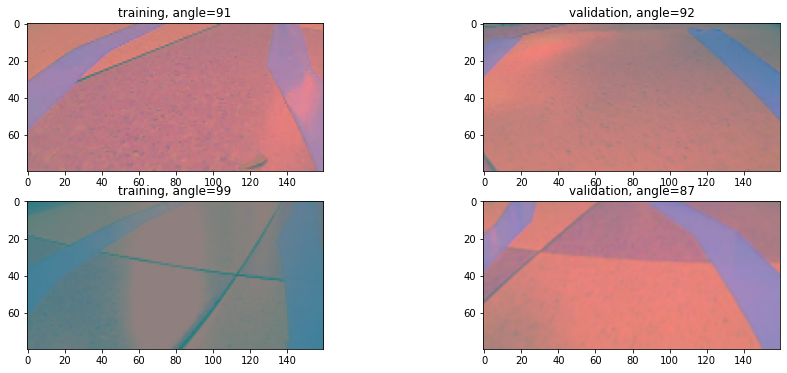

In [22]:
def batch_generator(image_paths, steering_angles, batch_size):

  batch_images = []
  batch_steering_angles = []

  for i in range(batch_size):
    index = np.random.randint(0, len(image_paths) - 1)
    image = cv2.imread(image_paths[index])
    
    image, steering_angle = augment_image(image, steering_angles[index])

    image = image_preprocess(image)

    batch_images.append(image)
    batch_steering_angles.append(steering_angle)

  yield(np.asarray(batch_images), np.asarray(batch_steering_angles))

#test

nrows = 2
ncols = 2

X_train_batch, y_train_batch = next(batch_generator(X_train, y_train, nrows))
X_valid_batch, y_valid_batch = next(batch_generator(X_val, y_val, nrows))

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 6))
#fig.tight_layout()

for i in range(nrows):
    axes[i][0].imshow(X_train_batch[i])
    axes[i][0].set_title("training, angle=%s" % y_train_batch[i])
    axes[i][1].imshow(X_valid_batch[i])
    axes[i][1].set_title("validation, angle=%s" % y_valid_batch[i])

#Model

In [12]:
from keras.backend import relu
def model_nvidia():

  model = keras.Sequential(name='Model_Nvidia')

  # conv layers

  model.add(keras.layers.Conv2D(24, 5, strides=(2, 2), input_shape=(80, 160, 3), activation='relu')) # 38x78 output
  model.add(keras.layers.Conv2D(36, 5, strides=(2, 2), activation='relu')) # 17x37 output
  model.add(keras.layers.Conv2D(48, 5, strides=(2, 2), activation='relu')) # 7x17 output

  model.add(keras.layers.Conv2D(64, 5, activation='relu')) # 3x13 output
  model.add(keras.layers.Conv2D(64, 3, activation='relu')) # 1x11 output

  # fully connected layers
  model.add(keras.layers.Flatten())

  model.add(keras.layers.Dense(100, activation='relu'))
  model.add(keras.layers.Dense(50, activation='relu'))
  model.add(keras.layers.Dense(10, activation='relu'))

  # output layer
  model.add(keras.layers.Dense(1))

  # loss
  opt = tf.keras.optimizers.Adam(learning_rate=0.001)
  model.compile(loss='mse', optimizer=opt)

  return model

In [13]:
model = model_nvidia()
print(model.summary())

Model: "Model_Nvidia"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 78, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 37, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 17, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 13, 64)         76864     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 11, 64)         36928     
                                                                 
 flatten (Flatten)           (None, 704)               0         
                                                                 
 dense (Dense)               (None, 100)              

##Training

In [23]:
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir,'autonomous_car_check.h5'), verbose=1, save_best_only=True)

# build data generator
'''datagen = tf.keras.preprocessing.image.ImageDataGenerator(brightness_range=(0.5,1.2), horizontal_flip=True, rescale=1./255, preprocessing_function=image_preprocess)

history = model.fit(datagen.flow( np.asarray(X_train), np.asarray(y_train), batch_size=32),
                              steps_per_epoch=len(X_train)/32,
                              epochs=10,
                              validation_data = datagen.flow( np.asarray(X_val), np.asarray(y_val), batch_size=8),
                              validation_steps=200,
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])'''

history = model.fit(batch_generator( X_train, y_train, batch_size=32),
                              epochs=10,
                              validation_data = batch_generator( X_val, y_val, batch_size=32),
                              validation_steps=8,
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])

model.save(os.path.join(model_output_dir,'autonomous_car_final.h5'))

AttributeError: ignored